This is a widget-heavy notebook that uses the nomenclature in [1] to design airfoils and analyse them.
You can analyse the vast array of airfoils in [1] by simply pasting the code of the airfoil below.
For the time being, this is the best way to design airfoils in viiflow without using other tools that generate points and paneling (e.g. XFLR5, XFOIL or Rhino). If you are looking at this on the viiflow website, pulling on the sliders does nothing, since this notebook is a static html export.

This notebook and the bezier and discretization logic embedded can be found at  __[github.com/airfoilDesigner](http://www.github.com/mranneberg/airfoilDesigner)__.

In [6]:
# Plot nice and large
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [12, 6] # Make plots bigger than default

# Import airfoil designer modules
from af_bezier import * 
from af_ui import * 
from af_pac import * 
from af_analysis import * 

In [7]:
# Import some widgets
import ipywidgets as widgets
from ipywidgets import interactive, interact
from ipywidgets import FloatSlider

# Default to read. After running this cell this is loaded.
# Airfoil codes can be found in [1]
kparam = B64read("K2ZW_awNMSkkS6I")

# "global" variables, i.e. those that I want to use from within the widget-functions. Probably not the intended way.
X = []
P = []
SR = []

# I know, very elegant.
# k1 to k15 are the parameters as in [1]
k1=FloatSlider(value = kparam[0], min=0, max=1, step=0.01, continuous_update=False,description="Nose Thck")
k2=FloatSlider(value = kparam[1], min=0, max=1, step=0.01, continuous_update=False,description="Lead Point")
k3=FloatSlider(value = kparam[2], min=0, max=1, step=0.01, continuous_update=False,description="Mid Point")
k4=FloatSlider(value = kparam[3], min=0, max=1, step=0.01, continuous_update=False,description="Trail Point")
k5=FloatSlider(value = kparam[4], min=0, max=1, step=0.01, continuous_update=False,description="Thickness")
k6=FloatSlider(value = kparam[5], min=0, max=1, step=0.01, continuous_update=False,description="Nose Thck")
k7=FloatSlider(value = kparam[6], min=0, max=1, step=0.01, continuous_update=False,description="Lead Point")
k8=FloatSlider(value = kparam[7], min=0, max=1, step=0.01, continuous_update=False,description="Mid Point")
k9=FloatSlider(value = kparam[8], min=0, max=1, step=0.01, continuous_update=False,description="Trail Point")
k10=FloatSlider(value = kparam[9], min=0, max=1, step=0.01, continuous_update=False,description="Thickness")
k11=FloatSlider(value = kparam[10], min=0, max=1, step=0.01, continuous_update=False,description="Top Len")
k12=FloatSlider(value = kparam[11], min=0, max=1, step=0.01, continuous_update=False,description="Bottom Len")
k13=FloatSlider(value = kparam[12], min=0, max=1, step=0.01, continuous_update=False,description="Angle Legs")
k14=FloatSlider(value = kparam[13], min=0, max=1, step=0.01, continuous_update=False,description="Angle TE")
k15=FloatSlider(value = kparam[14], min=0, max=1, step=0.01, continuous_update=False,description="Gap")


# Widget function
def manipulateAirfoil(k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,N,LEFAC,TEFAC,KAPFAC):
    
    # Airfoil Coordinates
    global P # Set of Bezier Points
    global kparam # k1 to k15
    ax=[]
    for kp in range(15):
        kparam[kp] = eval("k%u"%(kp+1))
    P = foilPoints(kparam)
    ds = 0.002
    (T,ArcPoints,Curvature) = pointsByArcLength(P,np.arange(0,1+ds,ds))
    (S,_,_) = getLength(P)
    
    # Airfoil Discretization
    global X # Airfoil coordinates
    global SR # Arclength discretization
    Curvature = discreteCurvature(ArcPoints)
    SR = repanelArclength(np.arange(0,1+ds,ds)*S,Curvature,ArcPoints[0,:],int(N),LEFAC,TEFAC,KAPFAC)
    (_,X,_) = pointsByArcLength(P,SR/max(SR))
    bezierPlot(ax,P);
    plt.plot(X[0,:],X[1,:],"+",color="#AAAAAA")
    plt.plot(X[0,:],X[1,:],"-k")
    plt.axis('equal')
    print("Airfoil Code:" + B64write(kparam))
    
# Set up the sliders
paramtop = widgets.VBox([widgets.HTML(
    value="Top Side Parameter"
),k1,k2,k3,k4,k5])
parambottom = widgets.VBox([widgets.HTML(
    value="Bottom Side Parameter"
),k6,k7,k8,k9,k10])
paramte = widgets.VBox([widgets.HTML(
    value="Trailing Edge Parameter"
),k11,k12,k13,k14,k15])
paramdisc = widgets.VBox([widgets.HBox([N,KAPFAC]),widgets.HBox([LEFAC,TEFAC])])
paramfoil = widgets.HBox([paramtop, parambottom,paramte])
ui = widgets.VBox([paramfoil,widgets.HTML(
    value="Discretization Parameter"
),paramdisc])

# Again, very elegant.
out=widgets.interactive_output(manipulateAirfoil, {'k1':k1,'k2':k2,'k3':k3,'k4':k4,'k5':k5,
                                                'k6':k6,'k7':k7,'k8':k8,'k9':k9,'k10':k10,
                                                'k11':k11,'k12':k12,'k13':k13,'k14':k14,'k15':k15,
                                                'N':N,'LEFAC':LEFAC,'TEFAC':TEFAC,'KAPFAC':KAPFAC})
display(ui, out)

Output()

In [3]:
# Save discretized airfoil points, if you want
savePoints('GOE222.dat',X,'GOE222')

In [4]:
# Calculate a polar, here with viiflow
RE = 1e6
NCRIT = 9
MACH = 0
(alv,clv,cdv,cmv,bl,p) = viiflowPolar(X,np.arange(-10,20,.5),RE,NCRIT,MACH)

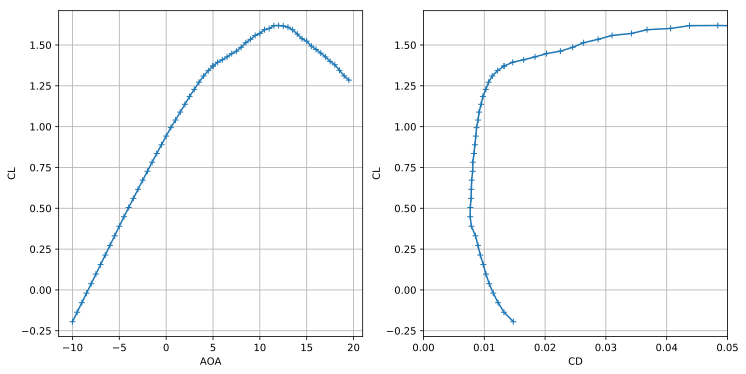

In [8]:
# Plot something
(fig,ax) = plt.subplots(1,2)
ax[0].plot(alv,clv,'-+')
ax[1].plot(cdv,clv,'-+')
ax[1].set_xlim(0,.05)
ax[0].grid(1)
ax[1].grid(1)
ax[0].set_xlabel('AOA')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')
ax[1].set_ylabel('CL');

[1] Melin, T. (2013). *Parametric Airfoil Catalog: An Aerodynamic and Geometric Comparison Between Parametrized and Point Cloud Airfoils - Part 1 and 2*.